# Code for Re-implementation of  “Learning Pairwise Similarity for Data Clustering”

### Authors: Kübra Duran, Marcin Damek

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import ParameterGrid
import seaborn as sns
import six
import random
import scipy.sparse as sp
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
import time
from sklearn.datasets import make_classification
import scipy.cluster.hierarchy as clst
import operator
import sys
import collections
from sklearn.model_selection import train_test_split

# Functions to prepare datasets

In [254]:
def get_100_rows_from_digit_data():
    digits_data = from_paper_example_data = np.array(pd.read_csv("optdigits.tra.csv"))
    X_digits = digits_data[:,0:-1]
    y_digits = digits_data[:,-1]
    x_ready_digits = []
    y_ready_digits = []
    existance = []
    for i in range(10):
        existance.append(0)
    for i in range(len(X_digits)):
        x = X_digits[i]
        y = y_digits[i]
        if existance[y] < 10:
            x_ready_digits.append(x)
            y_ready_digits.append(y)
            existance[y] += 1
    return (np.array(x_ready_digits), np.array(y_ready_digits))
      
def get_iris_data():
    iris_data = load_iris()
    X_iris = iris_data['data']
    y_iris = iris_data['target']
    return (X_iris, y_iris)

def get_breast_cancer_data():
    breast_cancer_data = load_breast_cancer()
    X_cancer = breast_cancer_data['data']
    y_cancer = breast_cancer_data['target']
    return (X_cancer, y_cancer)

def get_yeast_data_normalize():
    yeast_data_raw = pd.read_csv("yeast.data.csv", delim_whitespace=True, header=None, names=["Sequence Name", "Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5", "Feature 6", "Feature 7", "Feature 8", "Class"])
    yeast_data_raw[["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5", "Feature 6", "Feature 7", "Feature 8"]] = StandardScaler().fit_transform(yeast_data_raw[["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5", "Feature 6", "Feature 7", "Feature 8"]])
    yeast_data_raw = np.array(yeast_data_raw)
    return (yeast_data_raw[0:150,1:-1], yeast_data_raw[0:150,-1])
    
def get_yeast_data_log():
    yeast_data_raw = pd.read_csv("yeast.data.csv", delim_whitespace=True, header=None, names=["Sequence Name", "Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5", "Feature 6", "Feature 7", "Feature 8", "Class"])
    yeast_data_raw = yeast_data_raw.apply(lambda x: np.log(x) if x.name in ["Feature 1", "Feature 2", "Feature 3", "Feature 4", "Feature 5", "Feature 6", "Feature 7", "Feature 8"] else x, axis=1)
    yeast_data_raw = np.array(yeast_data_raw)
    return (yeast_data_raw[0:150:,1:-1], yeast_data_raw[0:150:,-1])

def simple_data():
    return (np.array([[1,1], [1.5,1.5], [2,2], [2.5,2.5], [3,3], [2.1, 2.1], [2.2, 2.2], [2.3,2.3],
                 [2.4,2.4], [2.6,2.6], [2.7,2.7], [2.8,2.8], [9.2,9.2], [9.3, 9.3], [9.4, 9.4], [9.5,9.5],
                    [6,6], [6.1,6.1], [6.2, 6.2], [6.3, 6.3], [6.4,6.4]]), 
            np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2]))

In [293]:
# every algorithm have seperated fuction to apply subsample for algorithm
def run_k_means(k, subsamples):
    clusters = []
    for subsample in subsamples:
        clustering = KMeans(n_clusters=k).fit(subsample)
        clusters.append(convert_labels_to_clusters(clustering.labels_, subsample))
    flat_clusters = []
    for sublist in clusters:
        for item in sublist:
            flat_clusters.append(item)
    return np.array(flat_clusters)
    
def run_SL(k, subsamples):
    clusters = []
    for subsample in subsamples:
        clustering = AgglomerativeClustering(n_clusters=k).fit(subsample)       
        clusters.append(convert_labels_to_clusters(clustering.labels_, subsample))
    flat_clusters = []
    for sublist in clusters:
        for item in sublist:
            flat_clusters.append(item)
    return np.array(flat_clusters)
            
def run_SC(k, sigma, subsamples):
    clusters = []
    for subsample in subsamples:
        clustering = SpectralClustering(n_clusters=k, gamma = sigma).fit(subsample)
        clusters.append(convert_labels_to_clusters(clustering.labels_, subsample))
    flat_clusters = []
    for sublist in clusters:
        for item in sublist:
            flat_clusters.append(item)
    return np.array(flat_clusters)

def run_KNN(k, subsamples, train_data, train_data_labels):
    clusters = []
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_data, train_data_labels)
    for subsample in subsamples:
        predicted = knn.predict(subsample)
        predicted = [ int(x) for x in predicted ]
        clusters.append(convert_labels_to_clusters(predicted, subsample))
    flat_clusters = []
    for sublist in clusters:
        for item in sublist:
            flat_clusters.append(item)
    return np.array(flat_clusters)

# function to create set of subsamples with use subsample_percent_of_data percent of all data
def create_subsamples(data, subsample_percent_of_data, number_of_subsamples):
    amount_of_data = len(data)
    amout_of_data_in_subsample = int(round(subsample_percent_of_data * amount_of_data))
    subsamples = []
    for i in range(number_of_subsamples):
        subsamples.append(np.array(random.sample(list(data), amout_of_data_in_subsample)))
    return np.array(subsamples)

In [294]:
# implementation of max rule for matrices
def get_max_from_matrixes(matrices):
    max_matrix = matrices[0]
    for matrix in matrices[1:]:
        max_matrix = np.maximum(max_matrix, matrix)
    return max_matrix

# calculation stab for clusters
def calculate_stab(clusters, C_matrix, dataset):
    clusters_and_stabs = []
    for cluster in clusters:
        stab = 0
        denominator = len(cluster) * (len(cluster) - 1)
        if denominator == 0:
            clusters_and_stabs.append((np.array(cluster), stab))
            continue
        for i in cluster:
            for j in cluster:
                if not np.array_equal(i,j):                     
                        stab += C_matrix[np.where(np.equal(dataset,i).all(1))[0][0]][np.where(np.equal(dataset,j).all(1))[0][0]] / denominator 
        clusters_and_stabs.append((np.array(cluster), stab ))                 
    return np.array(clusters_and_stabs)

# selection significant clusters above threshold
def select_significant_clusters(clusters_and_stabs, threshold):
    significant_clusters = []
    for cluster, stab in clusters_and_stabs:
        if stab > threshold:
            significant_clusters.append(cluster)
    return np.array(significant_clusters)

# function to convert labels produced by algorithms to clusters of data
def convert_labels_to_clusters(labels, dataset):
    classes = list(set(labels))
    clusters = []
    for i in range(len(classes)):
        clusters.append([])
    for label, set_of_data in zip(labels, dataset):
        clusters[label].append(set_of_data)
    return list(map(lambda x: np.array(x), clusters))

In [295]:
# calculation of matrix X, using clusters and subsamples
def create_C_matrix(dataset, clusters, subsamples):
    n = len(dataset)
    Ci = np.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            first_value = dataset[i]
            second_value = dataset[j]
            in_the_same_cluster = 0.0
            in_the_same_subsample = 0.0
            for subsample in subsamples:
                # if pair is in the same subsample
                if any(np.equal(subsample,first_value).all(1)) and any(np.equal(subsample,second_value).all(1)):
                    in_the_same_subsample += 1
            if in_the_same_subsample == 0:
                continue
            for cluster in clusters:
                # if pair is in the same cluster
                if any(np.equal(cluster,first_value).all(1)) and any(np.equal(cluster,second_value).all(1)):
                    in_the_same_cluster += 1
            Ci[i][j] = in_the_same_cluster/in_the_same_subsample
            if i != j:
                Ci[j][i] = in_the_same_cluster/in_the_same_subsample
    return Ci

# function to easier manage of running algorithms and calculation time of run
def run_algo(name, dataset, subsamples, threshold, k, sigma = 0, train_data = [], train_data_labels = [], knn_subsamples = []):
    start_time = time.time()
    if name =="k_means":
        print("\033[1m" + "K-means " + str(k) + "\033[0m")
        clusters = run_k_means(k, subsamples)
        C_matrix = create_C_matrix(dataset, clusters, subsamples)
        clusters_and_stabs = calculate_stab(clusters, C_matrix, dataset)
        significant_clusters = select_significant_clusters(clusters_and_stabs, threshold)
        M = create_C_matrix(dataset, significant_clusters, subsamples)
        print("Time:", int(time.time() - start_time), "s")
        return M
    if name == "sl":
        print("\033[1m" + "SL " + str(k) + "\033[0m")
        clusters = run_SL(k, subsamples)
        C_matrix = create_C_matrix(dataset, clusters, subsamples)
        clusters_and_stabs = calculate_stab(clusters, C_matrix, dataset)
        significant_clusters = select_significant_clusters(clusters_and_stabs, threshold)
        M = create_C_matrix(dataset, significant_clusters, subsamples)
        print("Time:", int(time.time() - start_time), "s")
        return M
    if name == "sc":
        print("\033[1m" + "SC " + str(k) +" "+ str(sigma) + "\033[0m")
        clusters = run_SC(k,sigma, subsamples)
        C_matrix = create_C_matrix(dataset, clusters, subsamples)
        clusters_and_stabs = calculate_stab(clusters, C_matrix, dataset)
        significant_clusters = select_significant_clusters(clusters_and_stabs, threshold)
        M = create_C_matrix(dataset, significant_clusters, subsamples)
        print("Time:", int(time.time() - start_time), "s")
        return M
    if name == "knn":
        print("\033[1m" + "KNN " + str(k) + "\033[0m")
        clusters = run_KNN(k, knn_subsamples, train_data, train_data_labels)
        C_matrix = create_C_matrix(dataset, clusters, subsamples)
        clusters_and_stabs = calculate_stab(clusters, C_matrix, dataset)
        significant_clusters = select_significant_clusters(clusters_and_stabs, threshold)
        M = create_C_matrix(dataset, significant_clusters, subsamples)
        print("Time:", int(time.time() - start_time), "s")
        return M

# generate final Cm matrix using max rule
def generate_Cm_matrix(Ci_matrixes):
    return get_max_from_matrixes(Ci_matrixes)

# create dissimilarity matrix
def dissimilarity(data):
    distances = np.zeros((len(data),len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            distances[i][j] = 1- data[i][j]
    return distances

# usage dendrogram
def apply_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = clst.dendrogram(*args, **kwargs, orientation='bottom')

    if not kwargs.get('no_plot', False):
        plt.xlabel('cluster size')
        plt.ylabel('distance')
        lifetimes = list()
        lifetimes.append(0.0)
        # Required parts are taken from the data returned by the dendrogram.
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                lifetimes.append(y-lifetimes[-1])
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return lifetimes

# calculate max lifetime 
def get_maxlifetime(lifetime):
    lifetime.pop(0)
    reverse_lifetime = lifetime[::-1]
    lfts = {i + 2: reverse_lifetime[i] for i in (range(len(lifetime)))}
    return max(lfts.items(), key=operator.itemgetter(1))[0]

# calculate effectiveness of solution
def calculate_Ci(Pstar_labels,Po_labels):
    hit = 0
    for i in range(len(Pstar_labels)):
        if (Pstar_labels[i] == Po_labels[i]):
            hit += 1
    return hit * 100 / (len(Pstar_labels))

In [302]:
# functions to run all scenarios from paper with selected k
def run_clustering_algorithms_for_iris_and_synthetic_without_sc(dataset, subsamples, threshold):
    Ci_matrixes = list()
    
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 3))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 12))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 15))

    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 3))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 12))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 15))
    return Ci_matrixes

def run_clustering_algorithms_for_iris_and_synthetic_with_sc(dataset, subsamples, threshold, Ci_matrixes):
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 3, 0.1))
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 12, 0.1))
    return Ci_matrixes

def run_clustering_algorithms_for_breast_cancer_without_sc(dataset, subsamples, threshold):
    Ci_matrixes = list()
    
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 2))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 3))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 10))

    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 2))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 3))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 10))
    return Ci_matrixes

def run_clustering_algorithms_for_breast_cancer_with_sc(dataset, subsamples, threshold, Ci_matrixes):  
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 2, 2))
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 3, 2))
    return Ci_matrixes

def run_clustering_algorithms_for_optdigits_without_sc(dataset, subsamples, threshold):
    Ci_matrixes = list()
    
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 15))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 20))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 30))

    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 15))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 20))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 30))
    return Ci_matrixes

def run_clustering_algorithms_for_optdigits_with_sc(dataset, subsamples, threshold, Ci_matrixes):
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 10, 20))
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 20, 20))
    return Ci_matrixes

def run_clustering_algorithms_for_yeast_log_without_sc(dataset, subsamples, threshold):
    Ci_matrixes = list()
    
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 7))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 20))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 30))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 40))

    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 7))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 20))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 30))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 40))
    return Ci_matrixes

def run_clustering_algorithms_for_yeast_log_with_sc(dataset, subsamples, threshold, Ci_matrixes):
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 5, 1))
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 7, 1))
    return Ci_matrixes

def run_clustering_algorithms_for_yeast_std_without_sc(dataset, subsamples, threshold):
    Ci_matrixes = list()
    
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 7))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 20))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 30))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 40))

    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 7))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 20))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 30))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 40))
    
    return Ci_matrixes

def run_clustering_algorithms_for_yeast_std_with_sc(dataset, subsamples, threshold, Ci_matrixes):
    Ci_matrixes = list()
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 5, 1))
    Ci_matrixes.append(run_algo("sc", dataset, subsamples, threshold, 7, 1))
    return Ci_matrixes

def run_clustering_algorithm_for_iris_with_knn(dataset, subsamples, threshold, train_data, train_data_labels, knn_subsamples):
    Ci_matrixes = list()
    
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 3))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 12))
    Ci_matrixes.append(run_algo("k_means", dataset, subsamples, threshold, 15))

    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 3))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 5))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 10))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 12))
    Ci_matrixes.append(run_algo("sl", dataset, subsamples, threshold, 15))

    Ci_matrixes.append(run_algo("knn", dataset, subsamples, threshold, 3, 0, train_data, train_data_labels, knn_subsamples))
    Ci_matrixes.append(run_algo("knn", dataset, subsamples, threshold, 5, 0, train_data, train_data_labels, knn_subsamples))
    Ci_matrixes.append(run_algo("knn", dataset, subsamples, threshold, 10, 0, train_data, train_data_labels, knn_subsamples))
    Ci_matrixes.append(run_algo("knn", dataset, subsamples, threshold, 12, 0, train_data, train_data_labels, knn_subsamples))
    Ci_matrixes.append(run_algo("knn", dataset, subsamples, threshold, 15, 0, train_data, train_data_labels, knn_subsamples))
    
    return Ci_matrixes

In [64]:
# usage dendrograms for getting highest lifetime and usage AC for clustering Cm matrix
def multi_eac(cm_matrix, data_labels):
    distmatrix = dissimilarity(cm_matrix)
    
    Pa_paths = clst.linkage(distmatrix, 'single')
    lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
    print(lifetime_Pa)
    plt.title('Hierarchical Clustering Dendrogram-SL')
    plt.show()
    max_Pa = get_maxlifetime(lifetime_Pa)
    print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)
    
    Pb_paths = clst.linkage(distmatrix, 'average')
    lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.5)
    plt.title('Hierarchical Clustering Dendrogram-AL')
    plt.show()
    max_Pb = get_maxlifetime(lifetime_Pb)
    print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)
    
    # For k-known case 'n_cluster' parameter will be set manually
    P_star = AgglomerativeClustering(n_clusters=max_Pb, linkage='average')
    P_star.fit(cm_matrix)
    Pstar_labels = P_star.labels_

    Po_labels = data_labels
    #Pstar_labels = replace_labels(Pstar_labels, 1, 0, 2, 1, 0, 2)
    Ci_value = calculate_Ci(Pstar_labels, Po_labels)
    print('Ci value:', Ci_value)
    
    print(Pstar_labels)
    print(Po_labels)

# Synthetic data

# Without SC

In [53]:
data_to_use, data_labels = simple_data()

K-means 3
Time: 0 s
K-means 5
Time: 0 s
K-means 10
Time: 0 s
K-means 12
Time: 0 s
K-means 15
Time: 0 s
SL 3
Time: 0 s
SL 5
Time: 0 s
SL 10
Time: 0 s
SL 12
Time: 0 s
SL 15
Time: 0 s


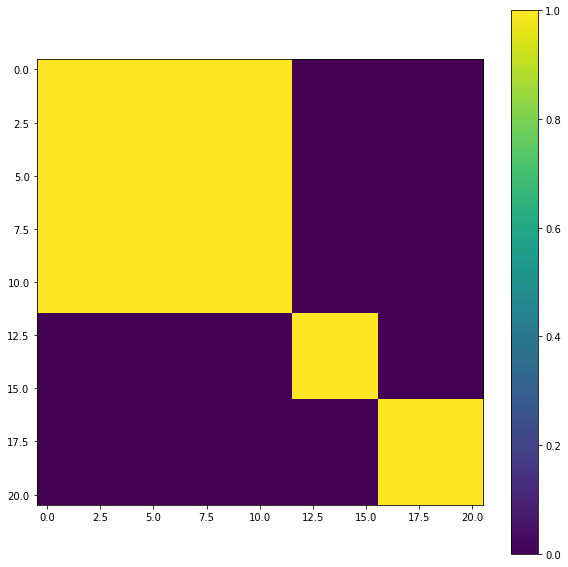

In [54]:
selected_dataset = data_to_use
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_synthetic = run_clustering_algorithms_for_iris_and_synthetic_without_sc(selected_dataset, subsamples, 0.95)
cm_matrix_synthetic = generate_Cm_matrix(ci_matrixes_synthetic)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_synthetic)
plt.colorbar()
plt.show()

C:\python\lib\site-packages\ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


[0.0, 3.0, 1.0]


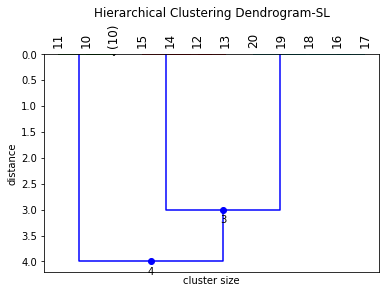

# of clusters for final partitioning in Pa according to lifetime criteria: 3


C:\python\lib\site-packages\ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


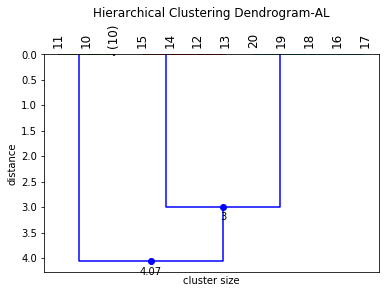

# of clusters for final partitioning in Pa according to lifetime criteria: 3
Ci value: 100.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]


In [59]:
multi_eac(cm_matrix_synthetic, data_labels)

# With SC

SC 3 0.1
Time: 0 s
SC 12 0.1
Time: 1 s


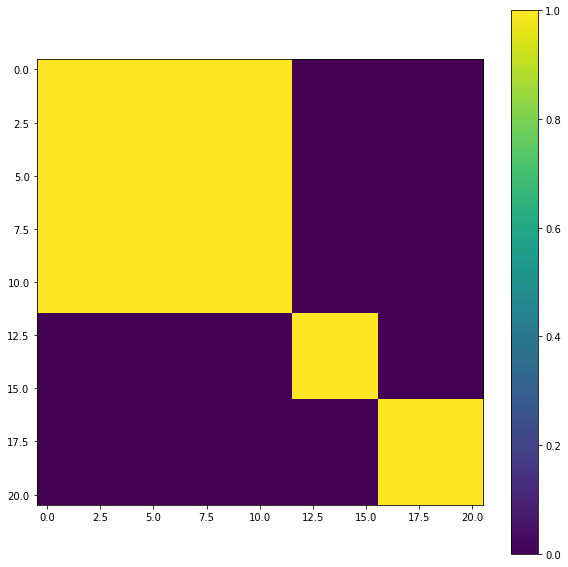

In [62]:
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_synthetic = run_clustering_algorithms_for_iris_and_synthetic_with_sc(selected_dataset, subsamples, 0.95, ci_matrixes_synthetic)
cm_matrix_synthetic_with_sc = generate_Cm_matrix(ci_matrixes_synthetic)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_synthetic_with_sc)
plt.colorbar()
plt.show()

C:\python\lib\site-packages\ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


[0.0, 3.0, 1.0]


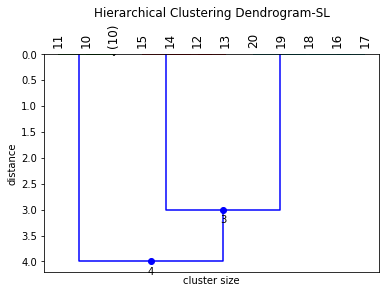

# of clusters for final partitioning in Pa according to lifetime criteria: 3


C:\python\lib\site-packages\ipykernel_launcher.py:12: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if sys.path[0] == '':


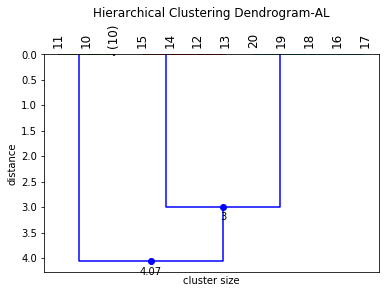

# of clusters for final partitioning in Pa according to lifetime criteria: 3
Ci value: 100.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 2]


In [65]:
multi_eac(cm_matrix_synthetic_with_sc, data_labels)

# Iris dataset

# Without SC

In [41]:
data_to_use, data_labels = get_iris_data()

K-means 3
Time: 16 s
K-means 5
Time: 18 s
K-means 10
Time: 16 s
K-means 12
Time: 19 s
K-means 15
Time: 20 s
SL 3
Time: 15 s
SL 5
Time: 15 s
SL 10
Time: 16 s
SL 12
Time: 18 s
SL 15
Time: 21 s


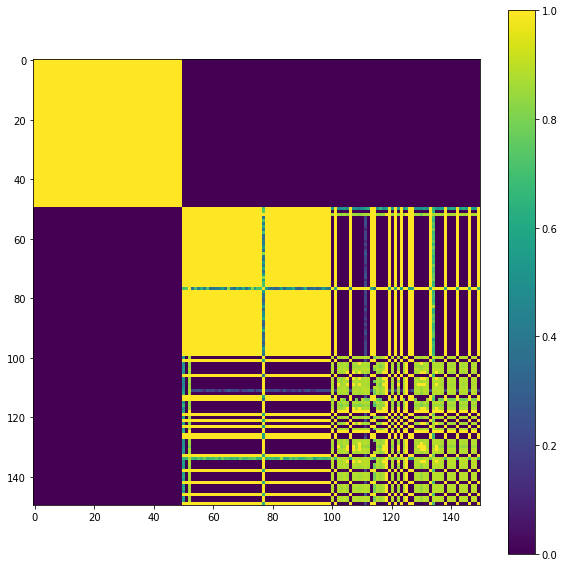

In [14]:
selected_dataset = data_to_use
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_iris = run_clustering_algorithms_for_iris_and_synthetic_without_sc(selected_dataset, subsamples, 0.95)
cm_matrix_iris = generate_Cm_matrix(ci_matrixes_iris)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_iris)
plt.colorbar()
plt.show()

[0.0, 0.3048396581535441, 0.2629665967069541, 0.5387950337157924, 1.003247166874095, 1.0346628235326811, 0.9379540288128829, 1.2939045421489987, 1.054032997286506, 1.7856157155467007, 1.4055242493617934, 7.472615226013536]


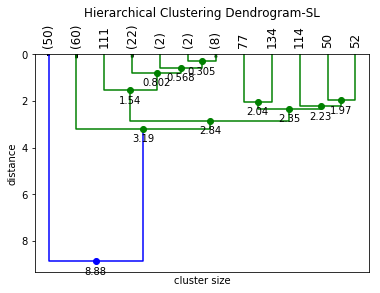

# of clusters for final partitioning in Pa according to lifetime criteria: 2


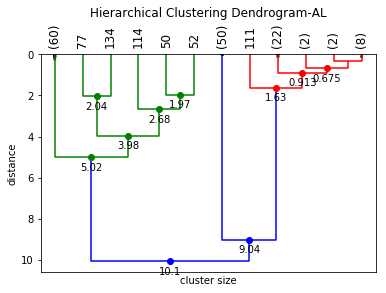

# of clusters for final partitioning in Pa according to lifetime criteria: 3
Ci value: 90.0


In [47]:
multi_eac(cm_matrix_iris, data_labels)

# With SC

SC 3 0.1
Time: 14 s
SC 12 0.1
Time: 18 s


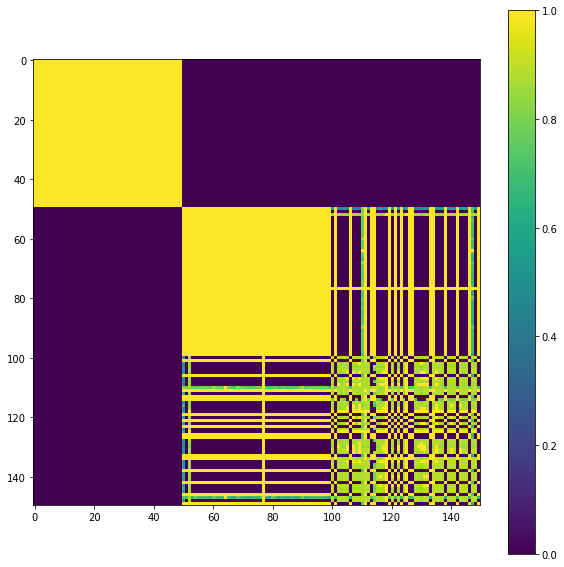

In [15]:
selected_dataset = data_to_use
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_iris1 = run_clustering_algorithms_for_iris_and_synthetic_with_sc(selected_dataset, subsamples, 0.95, ci_matrixes_iris)
cm_matrix_iris_with_sc = generate_Cm_matrix(ci_matrixes_iris1)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_iris_with_sc)
plt.colorbar()
plt.show()

[0.0, 0.29878738930223764, 0.2278096309786481, 0.5501984131666875, 0.08107134827908102, 0.5985741397644939, 1.2336375180640706, 0.6238248069206696, 1.5204078865007824, 1.5694760663404408, 3.805956088294229, 5.147586373717534]


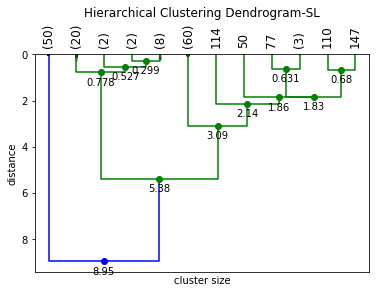

# of clusters for final partitioning in Pa according to lifetime criteria: 2


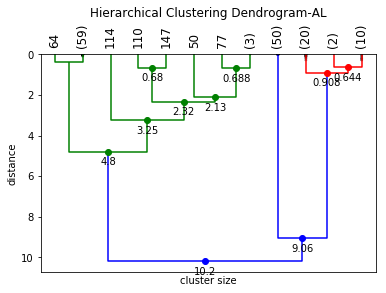

# of clusters for final partitioning in Pa according to lifetime criteria: 3
Ci value: 88.0


In [48]:
multi_eac(cm_matrix_iris_with_sc, data_labels)

# Breast_cancer dataset

# Without SC

In [71]:
data_to_use, data_labels = get_breast_cancer_data()

K-means 2
Time: 900 s
K-means 3
Time: 800 s
K-means 5
Time: 699 s
K-means 10
Time: 651 s
SL 2
Time: 790 s
SL 3
Time: 707 s
SL 5
Time: 686 s
SL 10
Time: 608 s


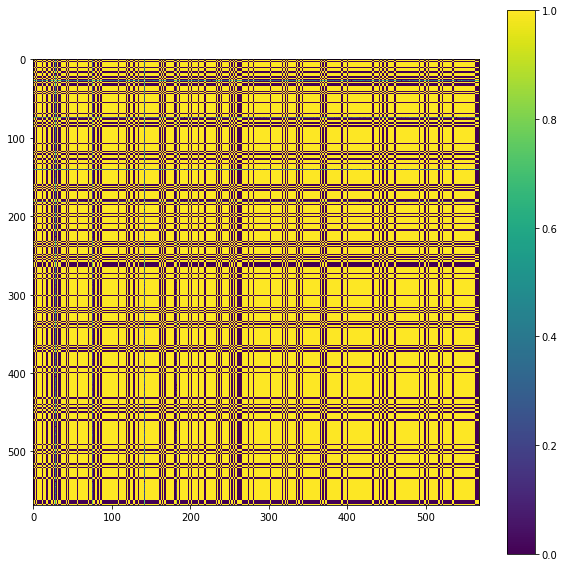

In [16]:
selected_dataset = data_to_use
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_breast_cancer = run_clustering_algorithms_for_breast_cancer_without_sc(selected_dataset, subsamples, 0.95)
cm_matrix_breast_cancer = generate_Cm_matrix(ci_matrixes_breast_cancer)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_breast_cancer)
plt.colorbar()
plt.show()

C:\python\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


[0.0, 0.23757383385089403, 0.05122155700183023, 0.19231740187291724, 0.19639510266828886, 0.3925191889157644, 0.43823134371594763, 1.8000848462668575, 0.7144084474830792, 1.8884293767443676, 1.2139305617876799, 12.049848622381862]


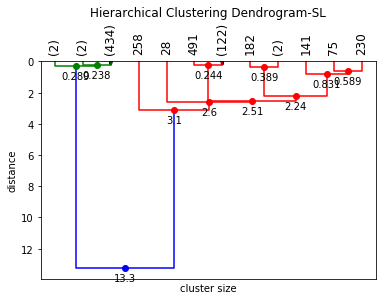

# of clusters for final partitioning in Pa according to lifetime criteria: 2


C:\python\lib\site-packages\ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()


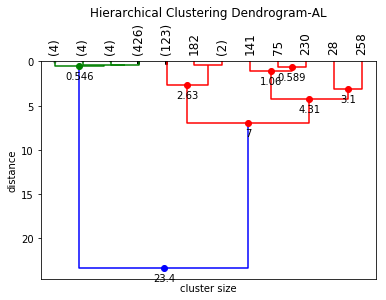

# of clusters for final partitioning in Pa according to lifetime criteria: 2
Ci value: 85.41300527240773


In [74]:
distmatrix = dissimilarity(cm_matrix_breast_cancer)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.5)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=max_Pb, linkage='average')
P_star.fit(cm_matrix_breast_cancer)
Pstar_labels = P_star.labels_

Po_labels = data_labels
Ci_value = calculate_Ci(Pstar_labels, Po_labels)
print('Ci value:', Ci_value)

# With SC

SC 2 2


C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\python\lib\site-packages\sklearn\utils\extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\python\lib\site-packages\sklearn\metrics\pairwise.py:304: RuntimeWarning: invalid value encountered in add
  distances += XX
C:\python\lib\site-packages\sklearn\utils\extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\python\lib\site-packages\sklearn\metric

Time: 1220 s
SC 3 2


C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\python\lib\site-packages\numpy\core\_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\python\lib\site-packages\sklearn\utils\extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\python\lib\site-packages\sklearn\utils\extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\python\lib\s

Time: 1262 s


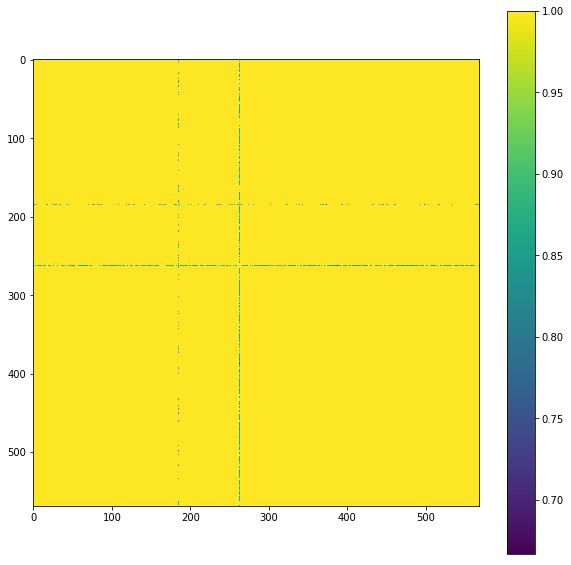

In [75]:
selected_dataset = data_to_use
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_breast_cancer1 = run_clustering_algorithms_for_breast_cancer_with_sc(selected_dataset, subsamples, 0.95, ci_matrixes_breast_cancer)
cm_matrix_breast_cancer_with_sc = generate_Cm_matrix(ci_matrixes_breast_cancer1)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_breast_cancer_with_sc)
plt.colorbar()
plt.show()

C:\python\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


[0.0, 0.2846333720114094, -0.2513000386780761, 0.28497179016314966, -0.1354870785289973, 0.16882041186233063, -0.019335700228178265, 0.17647054049185557, -0.019237521624245413, 0.20298353554467102, 1.130503322585641, 1.1281273487389587]


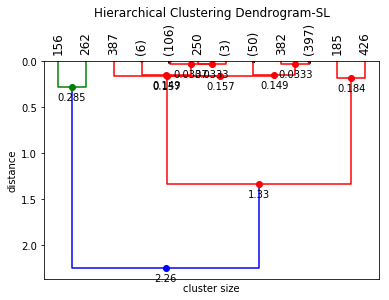

# of clusters for final partitioning in Pa according to lifetime criteria: 3


C:\python\lib\site-packages\ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()


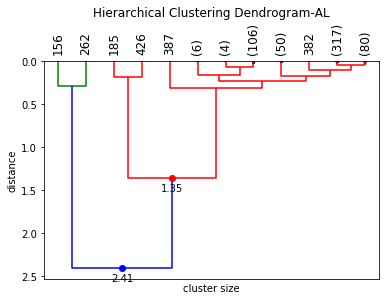

# of clusters for final partitioning in Pa according to lifetime criteria: 3
Ci value: 36.90685413005272
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0

In [79]:
distmatrix = dissimilarity(cm_matrix_breast_cancer_with_sc)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.5)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=2, linkage='average')
P_star.fit(cm_matrix_breast_cancer_with_sc)
Pstar_labels = P_star.labels_

Po_labels = data_labels
Ci_value = calculate_Ci(Pstar_labels, Po_labels)
print('Ci value:', Ci_value)

print(Po_labels)
print(Pstar_labels)

# optdigits dataset

# Without SC

In [103]:
data_to_use, data_labels = get_100_rows_from_digit_data()
selected_dataset = data_to_use

K-means 10
Time: 13 s
K-means 15
Time: 14 s
K-means 20
Time: 16 s
K-means 30
Time: 20 s
SL 10
Time: 14 s
SL 15
Time: 15 s
SL 20
Time: 18 s
SL 30
Time: 20 s


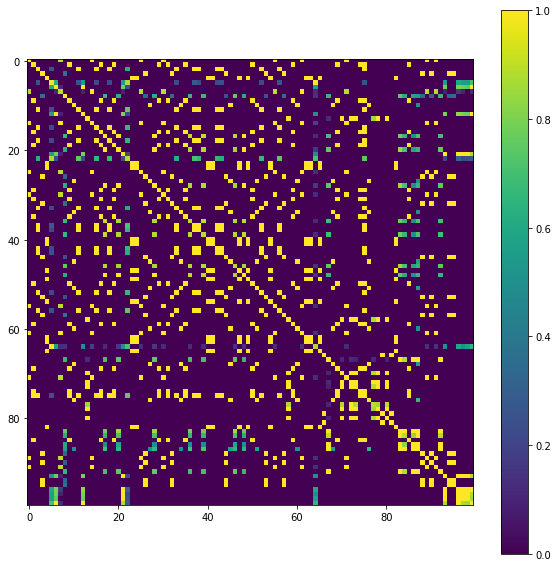

In [104]:
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_digits = run_clustering_algorithms_for_optdigits_without_sc(selected_dataset, subsamples, 0.75)
cm_matrix_optdigits = generate_Cm_matrix(ci_matrixes_digits)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_optdigits)
plt.colorbar()
plt.show()

[0.0, 2.8418900903649114, 0.22133595491557934, 2.966128987658863, 0.2600395239514839, 2.986238870256014, 0.28776891594837783, 3.121776508298086, 0.34232510683966844, 3.5306582393677486]


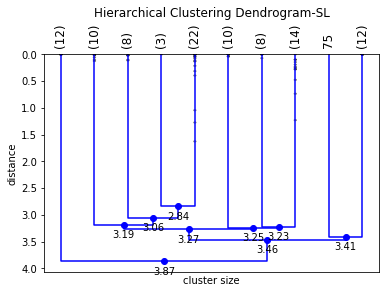

# of clusters for final partitioning in Pa according to lifetime criteria: 2


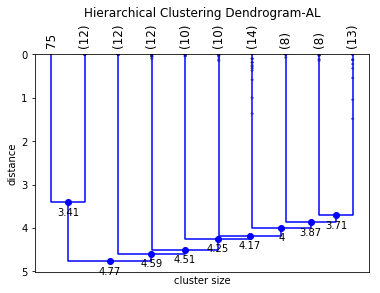

# of clusters for final partitioning in Pa according to lifetime criteria: 2
[0 7 4 6 2 5 5 0 8 7 1 9 5 3 0 4 7 8 4 7 8 5 9 1 2 0 6 1 8 7 0 7 6 9 1 9 3
 9 4 9 2 1 9 9 6 4 3 2 8 2 7 1 4 6 2 0 4 6 3 7 1 0 2 2 5 2 4 8 1 7 3 0 3 3
 7 9 1 3 3 4 3 4 2 8 8 9 8 1 6 0 6 0 8 5 6 6 5 5 5 5]
[6 8 1 4 5 0 0 6 2 8 7 1 0 3 6 1 8 2 1 8 2 0 1 5 5 6 4 7 2 8 6 8 4 1 7 8 2
 1 1 2 5 5 1 1 4 7 2 5 2 5 8 7 1 4 5 6 1 4 3 8 7 6 5 5 0 5 0 2 7 8 3 6 3 3
 8 9 7 3 3 0 3 0 5 2 2 8 2 2 4 6 4 6 2 0 4 4 0 0 0 0]


In [124]:
distmatrix = dissimilarity(cm_matrix_optdigits)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=10, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=10, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=10, linkage='average')
P_star.fit(cm_matrix_optdigits)
Pstar_labels = P_star.labels_

Po_labels = data_labels

print(Po_labels)
print(Pstar_labels)

In [111]:
remapped_values = []
for i in Pstar_labels:
    if i == 0:
        remapped_values.append(5)
    if i == 1:
        remapped_values.append(9)
    if i == 2:
        remapped_values.append(8)
    if i == 3:
        remapped_values.append(3)
    if i == 4:
        remapped_values.append(6)
    if i == 5:
        remapped_values.append(2)
    if i == 6:
        remapped_values.append(0)
    if i == 7:
        remapped_values.append(1)
    if i == 8:
        remapped_values.append(7)
    if i == 9:
        remapped_values.append(4)

Ci_value = calculate_Ci(remapped_values, Po_labels)
print('Ci value:', Ci_value)        

Ci value: 81.0


# With SC

SC 10 20


C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Gr

Time: 10 s
SC 20 20


C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Gr

Time: 12 s


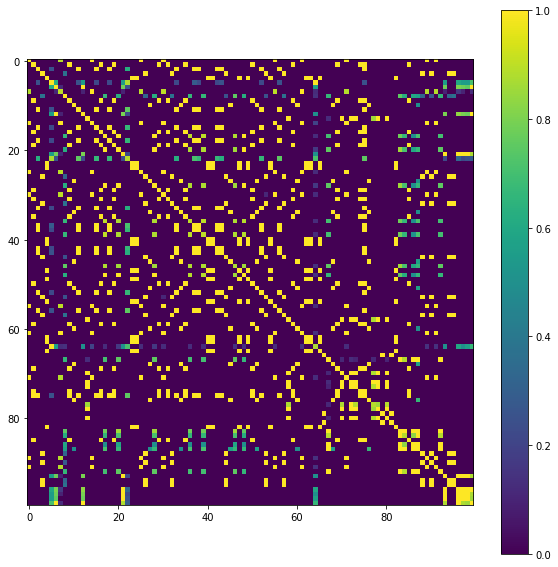

In [115]:
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_digits1 = run_clustering_algorithms_for_optdigits_with_sc(selected_dataset, subsamples, 0.80, ci_matrixes_digits)
cm_matrix_optdigits_with_sc = generate_Cm_matrix(ci_matrixes_digits1)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_optdigits_with_sc)
plt.colorbar()
plt.show()

[0.0, 2.8418900903649114, 0.22133595491557934, 2.966128987658863, 0.2600395239514839, 2.986238870256014, 0.28776891594837783, 3.121776508298086, 0.34232510683966844, 3.5306582393677486]


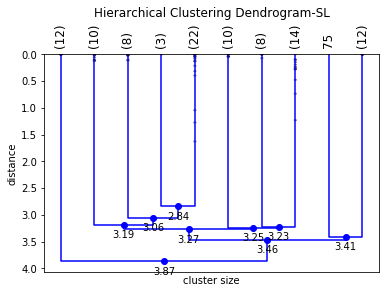

# of clusters for final partitioning in Pa according to lifetime criteria: 2


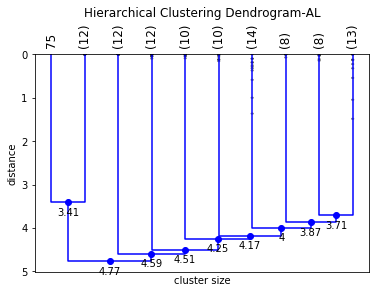

# of clusters for final partitioning in Pa according to lifetime criteria: 2
[0 7 4 6 2 5 5 0 8 7 1 9 5 3 0 4 7 8 4 7 8 5 9 1 2 0 6 1 8 7 0 7 6 9 1 9 3
 9 4 9 2 1 9 9 6 4 3 2 8 2 7 1 4 6 2 0 4 6 3 7 1 0 2 2 5 2 4 8 1 7 3 0 3 3
 7 9 1 3 3 4 3 4 2 8 8 9 8 1 6 0 6 0 8 5 6 6 5 5 5 5]
[6 8 1 4 5 0 0 6 2 8 7 1 0 3 6 1 8 2 1 8 2 0 1 5 5 6 4 7 2 8 6 8 4 1 7 8 2
 1 1 2 5 5 1 1 4 7 2 5 2 5 8 7 1 4 5 6 1 4 3 8 7 6 5 5 0 5 0 2 7 8 3 6 3 3
 8 9 7 3 3 0 3 0 5 2 2 8 2 2 4 6 4 6 2 0 4 4 0 0 0 0]


In [116]:
distmatrix = dissimilarity(cm_matrix_optdigits_with_sc)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=10, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=10, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=10, linkage='average')
P_star.fit(cm_matrix_optdigits_with_sc)
Pstar_labels = P_star.labels_

Po_labels = data_labels

print(Po_labels)
print(Pstar_labels)

In [117]:
remapped_values = []
for i in Pstar_labels:
    if i == 0:
        remapped_values.append(5)
    if i == 1:
        remapped_values.append(9)
    if i == 2:
        remapped_values.append(8)
    if i == 3:
        remapped_values.append(3)
    if i == 4:
        remapped_values.append(6)
    if i == 5:
        remapped_values.append(2)
    if i == 6:
        remapped_values.append(0)
    if i == 7:
        remapped_values.append(1)
    if i == 8:
        remapped_values.append(7)
    if i == 9:
        remapped_values.append(4)

Ci_value = calculate_Ci(remapped_values, Po_labels)
print('Ci value:', Ci_value)    

Ci value: 81.0


# yeast_log dataset

# without SC

In [126]:
data_to_use, data_labels = get_yeast_data_log()
selected_dataset = data_to_use

K-means 5
Time: 43 s
K-means 7
Time: 38 s
K-means 10
Time: 38 s
K-means 20
Time: 45 s
K-means 30
Time: 53 s
K-means 40
Time: 64 s
SL 5
Time: 42 s
SL 7
Time: 44 s
SL 10
Time: 45 s
SL 20
Time: 48 s
SL 30
Time: 61 s
SL 40
Time: 75 s


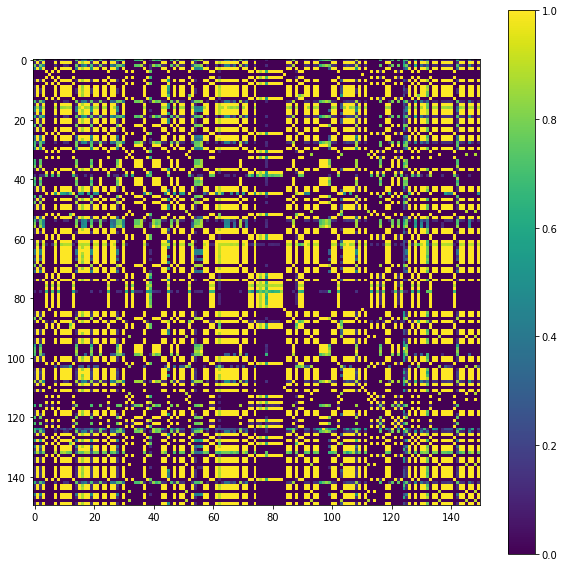

In [127]:
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_yeast_log = run_clustering_algorithms_for_yeast_log_without_sc(selected_dataset, subsamples, 0.9)
cm_matrix_yeast_log = generate_Cm_matrix(ci_matrixes_yeast_log)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_yeast_log)
plt.colorbar()
plt.show()

[0.0, 1.6472813960378554, 0.009243159066260054, 1.5132486757227626, 0.8814511859642131, 0.47232416595048, 2.3984693378382933, 0.24416131883772607, 2.970122484806621, 1.5506231185233994, 3.119666531025413, 2.2291273010972836]


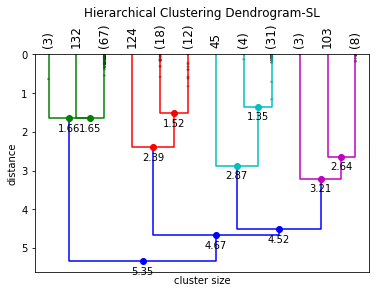

# of clusters for final partitioning in Pa according to lifetime criteria: 3


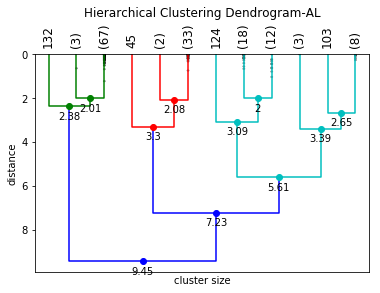

# of clusters for final partitioning in Pa according to lifetime criteria: 3
['MIT' 'MIT' 'MIT' 'NUC' 'MIT' 'CYT' 'MIT' 'NUC' 'MIT' 'CYT' 'NUC' 'NUC'
 'CYT' 'MIT' 'MIT' 'CYT' 'CYT' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT'
 'CYT' 'MIT' 'CYT' 'CYT' 'MIT' 'ME1' 'NUC' 'MIT' 'CYT' 'NUC' 'ME1' 'EXC'
 'MIT' 'CYT' 'MIT' 'MIT' 'ME2' 'ME2' 'ME2' 'ME3' 'VAC' 'NUC' 'ME2' 'EXC'
 'VAC' 'ME3' 'CYT' 'ME3' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'MIT'
 'MIT' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'EXC' 'CYT' 'CYT'
 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT'
 'MIT' 'ME3' 'ME3' 'EXC' 'NUC' 'CYT' 'CYT' 'MIT' 'CYT' 'NUC' 'CYT' 'ME3'
 'EXC' 'MIT' 'MIT' 'CYT' 'ME3' 'ME3' 'CYT' 'NUC' 'CYT' 'ME3' 'CYT' 'CYT'
 'CYT' 'CYT' 'POX' 'NUC' 'NUC' 'NUC' 'NUC' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT'
 'MIT' 'MIT' 'MIT' 'MIT' 'ME3' 'MIT' 'NUC' 'MIT' 'NUC' 'CYT' 'CYT' 'CYT'
 'CYT' 'NUC' 'NUC' 'CYT' 'ME3' 'NUC' 'CYT' 'NUC' 'CYT' 'NUC' 'NUC' 'NUC'
 'CYT' 'NUC' 'CYT' 'CYT' 'NUC' 'NUC']
[2 0 2 0 

In [148]:
distmatrix = dissimilarity(cm_matrix_yeast_log)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=10, linkage='average')
P_star.fit(cm_matrix_yeast_log)
Pstar_labels = P_star.labels_

Po_labels = data_labels

print(Po_labels)
print(Pstar_labels)

In [149]:
# remaping
mit = []
nuc = []
cyt = []
me1 = []
me2 = []
me3 = []
vac = []
exc = []
pox = []
erl = []

for true, predicted in zip(Po_labels, Pstar_labels):
    if true == "MIT":
        mit.append(predicted)
    if true == "NUC":
        nuc.append(predicted)
    if true == "CYT":
        cyt.append(predicted)
    if true == "ME1":
        me1.append(predicted)
    if true == "ME2":
        me2.append(predicted)
    if true == "ME3":
        me3.append(predicted)
    if true == "VAC":
        vac.append(predicted)
    if true == "EXC":
        exc.append(predicted)
    if true == "POX":
        pox.append(predicted)
    if true == "ERL":
        erl.append(predicted)

print(collections.Counter(mit))
print(collections.Counter(nuc))
print(collections.Counter(cyt))
print(collections.Counter(me1))
print(collections.Counter(me2))
print(collections.Counter(me3))
print(collections.Counter(vac))
print(collections.Counter(exc))
print(collections.Counter(pox))
print(collections.Counter(erl))

Counter({1: 24, 2: 11, 0: 5, 4: 2, 9: 1})
Counter({0: 19, 1: 5, 3: 5, 2: 2, 5: 1, 7: 1})
Counter({0: 36, 2: 6, 1: 4, 3: 1, 8: 1, 9: 1})
Counter({2: 2})
Counter({2: 4})
Counter({0: 8, 3: 2, 6: 1})
Counter({0: 1, 2: 1})
Counter({2: 4, 0: 1})
Counter({9: 1})
Counter()


In [150]:
remapped_values = []
for i in Pstar_labels:
    if i == 0:
        remapped_values.append('CYT')
    if i == 1:
        remapped_values.append('MIT')
    if i == 2:
        remapped_values.append('VAC')
    if i == 3:
        remapped_values.append('NUC')
    if i == 4:
        remapped_values.append('ME2')
    if i == 5:
        remapped_values.append('EXC')
    if i == 6:
        remapped_values.append('ME3')
    if i == 7:
        remapped_values.append('ERL')
    if i == 8:
        remapped_values.append('ME1')
    if i == 9:
        remapped_values.append('POX')

Ci_value = calculate_Ci(remapped_values, Po_labels)
print('Ci value:', Ci_value)    

Ci value: 45.333333333333336


# with SC

SC 5 1
Time: 39 s
SC 7 1
Time: 43 s


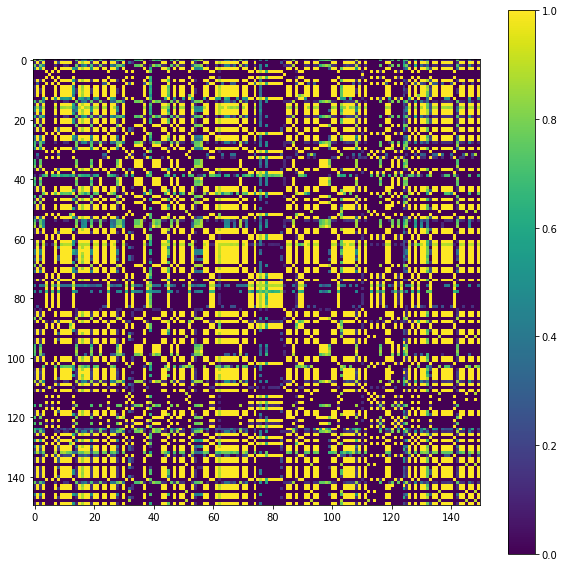

In [142]:
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_yeast_log1 = run_clustering_algorithms_for_yeast_log_with_sc(selected_dataset, subsamples, 0.9, ci_matrixes_yeast_log)
cm_matrix_yeast_log_with_sc = generate_Cm_matrix(ci_matrixes_yeast_log1)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_yeast_log_with_sc)
plt.colorbar()
plt.show()

[0.0, 3.214283803644347, -1.2221718947278917, 3.238464111483928, -0.9003138155233845, 3.693769430774219, -0.7652780136196977, 4.0477827003095115, 0.02864885022497443, 4.258348422461839, 0.5509819307902655, 4.811624909422892]


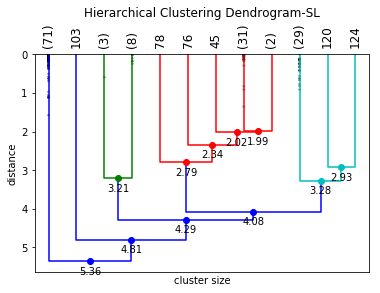

# of clusters for final partitioning in Pa according to lifetime criteria: 2


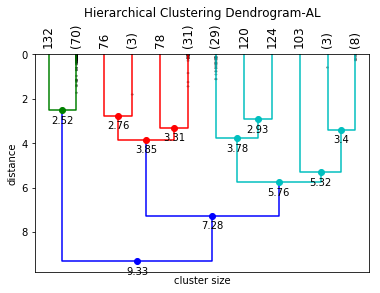

# of clusters for final partitioning in Pa according to lifetime criteria: 3
['MIT' 'MIT' 'MIT' 'NUC' 'MIT' 'CYT' 'MIT' 'NUC' 'MIT' 'CYT' 'NUC' 'NUC'
 'CYT' 'MIT' 'MIT' 'CYT' 'CYT' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT'
 'CYT' 'MIT' 'CYT' 'CYT' 'MIT' 'ME1' 'NUC' 'MIT' 'CYT' 'NUC' 'ME1' 'EXC'
 'MIT' 'CYT' 'MIT' 'MIT' 'ME2' 'ME2' 'ME2' 'ME3' 'VAC' 'NUC' 'ME2' 'EXC'
 'VAC' 'ME3' 'CYT' 'ME3' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'MIT'
 'MIT' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'EXC' 'CYT' 'CYT'
 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT'
 'MIT' 'ME3' 'ME3' 'EXC' 'NUC' 'CYT' 'CYT' 'MIT' 'CYT' 'NUC' 'CYT' 'ME3'
 'EXC' 'MIT' 'MIT' 'CYT' 'ME3' 'ME3' 'CYT' 'NUC' 'CYT' 'ME3' 'CYT' 'CYT'
 'CYT' 'CYT' 'POX' 'NUC' 'NUC' 'NUC' 'NUC' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT'
 'MIT' 'MIT' 'MIT' 'MIT' 'ME3' 'MIT' 'NUC' 'MIT' 'NUC' 'CYT' 'CYT' 'CYT'
 'CYT' 'NUC' 'NUC' 'CYT' 'ME3' 'NUC' 'CYT' 'NUC' 'CYT' 'NUC' 'NUC' 'NUC'
 'CYT' 'NUC' 'CYT' 'CYT' 'NUC' 'NUC']
[2 1 2 1 

In [151]:
distmatrix = dissimilarity(cm_matrix_yeast_log_with_sc)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=10, linkage='average')
P_star.fit(cm_matrix_yeast_log_with_sc)
Pstar_labels = P_star.labels_

Po_labels = data_labels

print(Po_labels)
print(Pstar_labels)

In [152]:
# remaping
mit = []
nuc = []
cyt = []
me1 = []
me2 = []
me3 = []
vac = []
exc = []
pox = []
erl = []

for true, predicted in zip(Po_labels, Pstar_labels):
    if true == "MIT":
        mit.append(predicted)
    if true == "NUC":
        nuc.append(predicted)
    if true == "CYT":
        cyt.append(predicted)
    if true == "ME1":
        me1.append(predicted)
    if true == "ME2":
        me2.append(predicted)
    if true == "ME3":
        me3.append(predicted)
    if true == "VAC":
        vac.append(predicted)
    if true == "EXC":
        exc.append(predicted)
    if true == "POX":
        pox.append(predicted)
    if true == "ERL":
        erl.append(predicted)

print("MIT",collections.Counter(mit))
print("NUC",collections.Counter(nuc))
print("CYT",collections.Counter(cyt))
print("me1",collections.Counter(me1))
print("me2",collections.Counter(me2))
print("me3",collections.Counter(me3))
print("vac",collections.Counter(vac))
print("exc",collections.Counter(exc))
print("pox",collections.Counter(pox))
print("erl",collections.Counter(erl))

MIT Counter({5: 22, 2: 10, 1: 5, 0: 3, 4: 1, 7: 1, 8: 1})
NUC Counter({1: 19, 3: 5, 5: 5, 2: 2, 0: 1, 9: 1})
CYT Counter({1: 37, 2: 6, 5: 4, 3: 1, 7: 1})
me1 Counter({2: 2})
me2 Counter({2: 4})
me3 Counter({1: 8, 3: 2, 6: 1})
vac Counter({1: 1, 2: 1})
exc Counter({2: 4, 1: 1})
pox Counter({7: 1})
erl Counter()


In [153]:
remapped_values = []
for i in Pstar_labels:
    if i == 0:
        remapped_values.append('ME1')
    if i == 1:
        remapped_values.append('CYT')
    if i == 2:
        remapped_values.append('ME2')
    if i == 3:
        remapped_values.append('NUC')
    if i == 4:
        remapped_values.append('VAC')
    if i == 5:
        remapped_values.append('MIT')
    if i == 6:
        remapped_values.append('ME3')
    if i == 7:
        remapped_values.append('POX')
    if i == 8:
        remapped_values.append('EXC')
    if i == 9:
        remapped_values.append('ERL')

Ci_value = calculate_Ci(remapped_values, Po_labels)
print('Ci value:', Ci_value) 

Ci value: 46.666666666666664


# yeast_std dataset

# without SC

In [154]:
data_to_use, data_labels = get_yeast_data_normalize()
selected_dataset = data_to_use

K-means 5
Time: 43 s
K-means 7
Time: 40 s
K-means 10
Time: 35 s
K-means 20
Time: 42 s
K-means 30
Time: 51 s
K-means 40
Time: 59 s
SL 5
Time: 39 s
SL 7
Time: 39 s
SL 10
Time: 39 s
SL 20
Time: 48 s
SL 30
Time: 57 s
SL 40
Time: 68 s


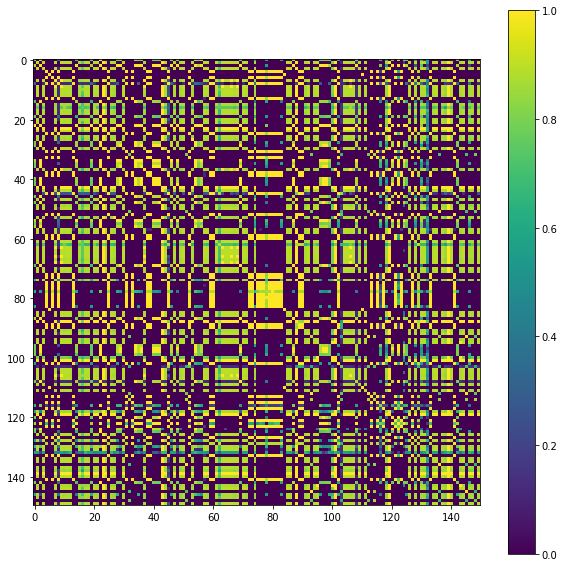

In [155]:
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_yeast_std = run_clustering_algorithms_for_yeast_std_without_sc(selected_dataset, subsamples, 0.9)
cm_matrix_yeast_std = generate_Cm_matrix(ci_matrixes_yeast_std)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_yeast_std)
plt.colorbar()
plt.show()

[0.0, 1.9272757993610363, 0.018063199595618196, 2.0430791209778203, 0.7635105999607443, 1.3609381821627413, 1.4648278562246735, 0.7811993676756477, 2.2950871651752096, 1.6456659541399667, 2.8697397739080546, 2.2063628024624458]


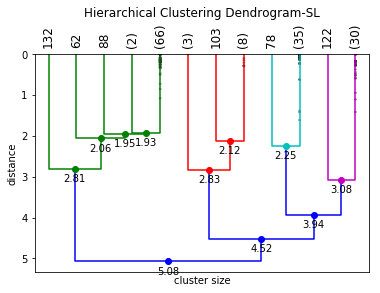

# of clusters for final partitioning in Pa according to lifetime criteria: 3


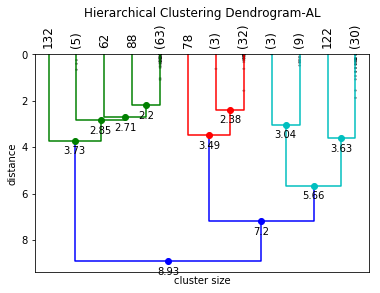

# of clusters for final partitioning in Pa according to lifetime criteria: 3
['MIT' 'MIT' 'MIT' 'NUC' 'MIT' 'CYT' 'MIT' 'NUC' 'MIT' 'CYT' 'NUC' 'NUC'
 'CYT' 'MIT' 'MIT' 'CYT' 'CYT' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT'
 'CYT' 'MIT' 'CYT' 'CYT' 'MIT' 'ME1' 'NUC' 'MIT' 'CYT' 'NUC' 'ME1' 'EXC'
 'MIT' 'CYT' 'MIT' 'MIT' 'ME2' 'ME2' 'ME2' 'ME3' 'VAC' 'NUC' 'ME2' 'EXC'
 'VAC' 'ME3' 'CYT' 'ME3' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'MIT'
 'MIT' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'EXC' 'CYT' 'CYT'
 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT'
 'MIT' 'ME3' 'ME3' 'EXC' 'NUC' 'CYT' 'CYT' 'MIT' 'CYT' 'NUC' 'CYT' 'ME3'
 'EXC' 'MIT' 'MIT' 'CYT' 'ME3' 'ME3' 'CYT' 'NUC' 'CYT' 'ME3' 'CYT' 'CYT'
 'CYT' 'CYT' 'POX' 'NUC' 'NUC' 'NUC' 'NUC' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT'
 'MIT' 'MIT' 'MIT' 'MIT' 'ME3' 'MIT' 'NUC' 'MIT' 'NUC' 'CYT' 'CYT' 'CYT'
 'CYT' 'NUC' 'NUC' 'CYT' 'ME3' 'NUC' 'CYT' 'NUC' 'CYT' 'NUC' 'NUC' 'NUC'
 'CYT' 'NUC' 'CYT' 'CYT' 'NUC' 'NUC']
[2 1 2 1 

In [156]:
distmatrix = dissimilarity(cm_matrix_yeast_std)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=10, linkage='average')
P_star.fit(cm_matrix_yeast_std)
Pstar_labels = P_star.labels_

Po_labels = data_labels

print(Po_labels)
print(Pstar_labels)

In [157]:
# remaping
mit = []
nuc = []
cyt = []
me1 = []
me2 = []
me3 = []
vac = []
exc = []
pox = []
erl = []

for true, predicted in zip(Po_labels, Pstar_labels):
    if true == "MIT":
        mit.append(predicted)
    if true == "NUC":
        nuc.append(predicted)
    if true == "CYT":
        cyt.append(predicted)
    if true == "ME1":
        me1.append(predicted)
    if true == "ME2":
        me2.append(predicted)
    if true == "ME3":
        me3.append(predicted)
    if true == "VAC":
        vac.append(predicted)
    if true == "EXC":
        exc.append(predicted)
    if true == "POX":
        pox.append(predicted)
    if true == "ERL":
        erl.append(predicted)

print("MIT",collections.Counter(mit))
print("NUC",collections.Counter(nuc))
print("CYT",collections.Counter(cyt))
print("me1",collections.Counter(me1))
print("me2",collections.Counter(me2))
print("me3",collections.Counter(me3))
print("vac",collections.Counter(vac))
print("exc",collections.Counter(exc))
print("pox",collections.Counter(pox))
print("erl",collections.Counter(erl))

MIT Counter({0: 25, 2: 10, 1: 3, 8: 2, 5: 1, 6: 1, 7: 1})
NUC Counter({1: 17, 0: 6, 3: 6, 2: 2, 8: 1, 9: 1})
CYT Counter({1: 34, 2: 6, 0: 4, 8: 2, 3: 1, 4: 1, 7: 1})
me1 Counter({2: 2})
me2 Counter({2: 4})
me3 Counter({1: 8, 3: 2, 2: 1})
vac Counter({1: 1, 2: 1})
exc Counter({2: 4, 1: 1})
pox Counter({7: 1})
erl Counter()


In [158]:
remapped_values = []
for i in Pstar_labels:
    if i == 0:
        remapped_values.append('MIT')
    if i == 1:
        remapped_values.append('CYT')
    if i == 2:
        remapped_values.append('ME2')
    if i == 3:
        remapped_values.append('NUC')
    if i == 4:
        remapped_values.append('ME1')
    if i == 5:
        remapped_values.append('ME3')
    if i == 6:
        remapped_values.append('VAC')
    if i == 7:
        remapped_values.append('POX')
    if i == 8:
        remapped_values.append('EXC')
    if i == 9:
        remapped_values.append('ERL')

Ci_value = calculate_Ci(remapped_values, Po_labels)
print('Ci value:', Ci_value) 

Ci value: 46.666666666666664


# with SC

SC 5 1
Time: 45 s
SC 7 1
Time: 41 s


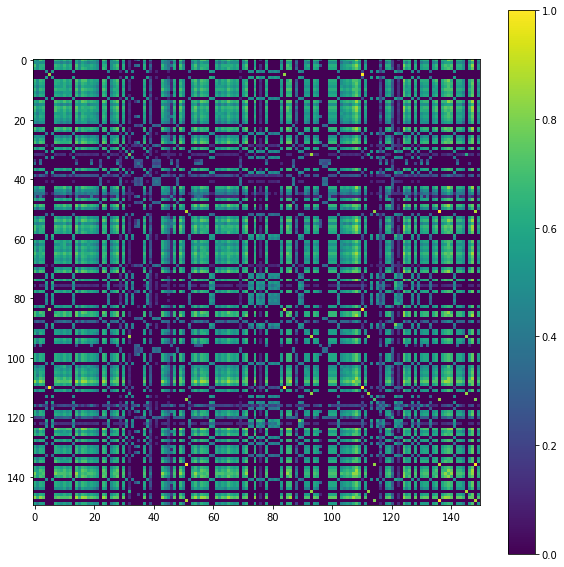

In [160]:
subsamples = create_subsamples(selected_dataset, 0.9, 10)
ci_matrixes_yeast_std1 = run_clustering_algorithms_for_yeast_std_with_sc(selected_dataset, subsamples, 0.9, ci_matrixes_yeast_std)
cm_matrix_yeast_std_with_sc = generate_Cm_matrix(ci_matrixes_yeast_std1)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_yeast_std_with_sc)
plt.colorbar()
plt.show()

[0.0, 1.9272757993610363, 0.018063199595618196, 2.0430791209778203, 0.7635105999607443, 1.3609381821627413, 1.4648278562246735, 0.7811993676756477, 2.2950871651752096, 1.6456659541399667, 2.8697397739080546, 2.2063628024624458]


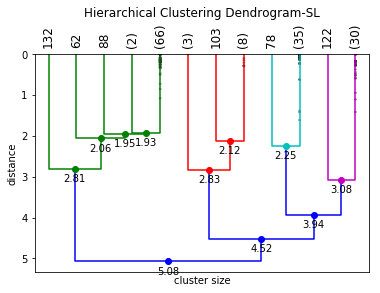

# of clusters for final partitioning in Pa according to lifetime criteria: 3


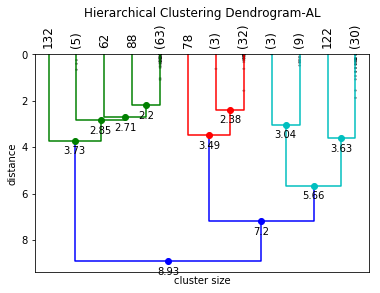

# of clusters for final partitioning in Pa according to lifetime criteria: 3
['MIT' 'MIT' 'MIT' 'NUC' 'MIT' 'CYT' 'MIT' 'NUC' 'MIT' 'CYT' 'NUC' 'NUC'
 'CYT' 'MIT' 'MIT' 'CYT' 'CYT' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT'
 'CYT' 'MIT' 'CYT' 'CYT' 'MIT' 'ME1' 'NUC' 'MIT' 'CYT' 'NUC' 'ME1' 'EXC'
 'MIT' 'CYT' 'MIT' 'MIT' 'ME2' 'ME2' 'ME2' 'ME3' 'VAC' 'NUC' 'ME2' 'EXC'
 'VAC' 'ME3' 'CYT' 'ME3' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'MIT'
 'MIT' 'NUC' 'NUC' 'NUC' 'CYT' 'CYT' 'CYT' 'CYT' 'CYT' 'EXC' 'CYT' 'CYT'
 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT'
 'MIT' 'ME3' 'ME3' 'EXC' 'NUC' 'CYT' 'CYT' 'MIT' 'CYT' 'NUC' 'CYT' 'ME3'
 'EXC' 'MIT' 'MIT' 'CYT' 'ME3' 'ME3' 'CYT' 'NUC' 'CYT' 'ME3' 'CYT' 'CYT'
 'CYT' 'CYT' 'POX' 'NUC' 'NUC' 'NUC' 'NUC' 'MIT' 'MIT' 'MIT' 'MIT' 'MIT'
 'MIT' 'MIT' 'MIT' 'MIT' 'ME3' 'MIT' 'NUC' 'MIT' 'NUC' 'CYT' 'CYT' 'CYT'
 'CYT' 'NUC' 'NUC' 'CYT' 'ME3' 'NUC' 'CYT' 'NUC' 'CYT' 'NUC' 'NUC' 'NUC'
 'CYT' 'NUC' 'CYT' 'CYT' 'NUC' 'NUC']
[2 1 2 1 

In [161]:
distmatrix = dissimilarity(cm_matrix_yeast_std)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=10, linkage='average')
P_star.fit(cm_matrix_yeast_std)
Pstar_labels = P_star.labels_

Po_labels = data_labels

print(Po_labels)
print(Pstar_labels)

In [162]:
# remaping
mit = []
nuc = []
cyt = []
me1 = []
me2 = []
me3 = []
vac = []
exc = []
pox = []
erl = []

for true, predicted in zip(Po_labels, Pstar_labels):
    if true == "MIT":
        mit.append(predicted)
    if true == "NUC":
        nuc.append(predicted)
    if true == "CYT":
        cyt.append(predicted)
    if true == "ME1":
        me1.append(predicted)
    if true == "ME2":
        me2.append(predicted)
    if true == "ME3":
        me3.append(predicted)
    if true == "VAC":
        vac.append(predicted)
    if true == "EXC":
        exc.append(predicted)
    if true == "POX":
        pox.append(predicted)
    if true == "ERL":
        erl.append(predicted)

print("MIT",collections.Counter(mit))
print("NUC",collections.Counter(nuc))
print("CYT",collections.Counter(cyt))
print("me1",collections.Counter(me1))
print("me2",collections.Counter(me2))
print("me3",collections.Counter(me3))
print("vac",collections.Counter(vac))
print("exc",collections.Counter(exc))
print("pox",collections.Counter(pox))
print("erl",collections.Counter(erl))

MIT Counter({0: 25, 2: 10, 1: 3, 8: 2, 5: 1, 6: 1, 7: 1})
NUC Counter({1: 17, 0: 6, 3: 6, 2: 2, 8: 1, 9: 1})
CYT Counter({1: 34, 2: 6, 0: 4, 8: 2, 3: 1, 4: 1, 7: 1})
me1 Counter({2: 2})
me2 Counter({2: 4})
me3 Counter({1: 8, 3: 2, 2: 1})
vac Counter({1: 1, 2: 1})
exc Counter({2: 4, 1: 1})
pox Counter({7: 1})
erl Counter()


In [163]:
remapped_values = []
for i in Pstar_labels:
    if i == 0:
        remapped_values.append('MIT')
    if i == 1:
        remapped_values.append('CYT')
    if i == 2:
        remapped_values.append('ME2')
    if i == 3:
        remapped_values.append('NUC')
    if i == 4:
        remapped_values.append('ERL')
    if i == 5:
        remapped_values.append('EXC')
    if i == 6:
        remapped_values.append('ME1')
    if i == 7:
        remapped_values.append('POX')
    if i == 8:
        remapped_values.append('ME3')
    if i == 9:
        remapped_values.append('VAC')

Ci_value = calculate_Ci(remapped_values, Po_labels)
print('Ci value:', Ci_value) 

Ci value: 46.666666666666664


# Improvement of accuracy

In [301]:
def create_train_dataset(data, labels, subsample_percent_of_data, number_of_subsamples):
    subsamples = []
    data_and_labels = np.column_stack((data, labels))
    train, test = train_test_split(data_and_labels, train_size = 0.70)
    amout_of_data_in_subsample = int(round(len(test) * subsample_percent_of_data))
    
    return (np.array(train[:,0:-1]), np.array(train[:,-1]))  

K-means 3
Time: 15 s
K-means 5
Time: 16 s
K-means 10
Time: 16 s
K-means 12
Time: 17 s
K-means 15
Time: 19 s
SL 3
Time: 14 s
SL 5
Time: 15 s
SL 10
Time: 15 s
SL 12
Time: 17 s
SL 15
Time: 19 s
KNN 3
Time: 9 s
KNN 5
Time: 10 s
KNN 10
Time: 11 s
KNN 12
Time: 10 s
KNN 15
Time: 9 s


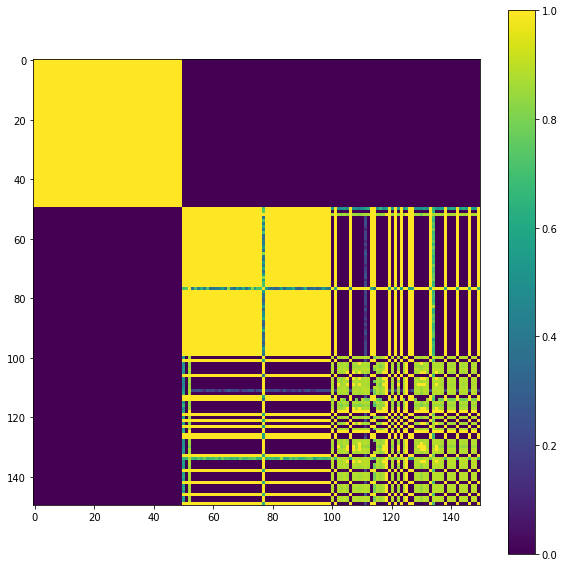

In [306]:
data_to_use, data_labels = get_iris_data()
selected_dataset = data_to_use
regular_subsamples = create_subsamples(data_to_use, 0.9, 10)
knn_subsamples, train_data, train_data_labels = create_subsamples_and_train_dataset(selected_dataset, data_labels, 0.99, 10)
ci_matrixes_iris_knn = run_clustering_algorithm_for_iris_with_knn(selected_dataset, regular_subsamples, 0.95, train_data, train_data_labels, knn_subsamples)
cm_matrix_iris_knn = generate_Cm_matrix(ci_matrixes_iris_knn)
plt.figure(figsize=(10, 10))
plt.imshow(cm_matrix_iris)
plt.colorbar()
plt.show()

[0.0, 1.7169704506323549, 0.6334461724026452, 2.549779939099071, -1.1965456970581005, 2.575713776675931, 0.3948495809428927, 3.161908670330238, 0.690528711124486, 3.2604613944453718, 1.1412415330738765, 7.907632518355919]


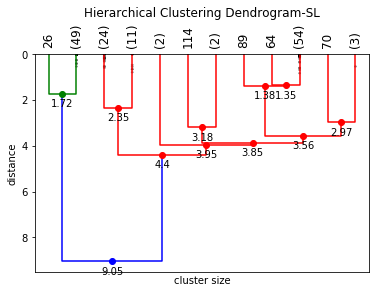

# of clusters for final partitioning in Pa according to lifetime criteria: 2


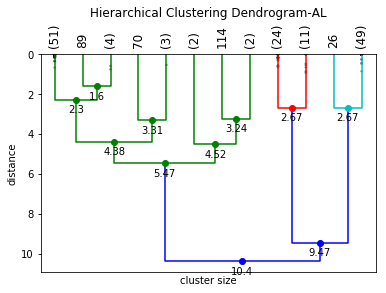

# of clusters for final partitioning in Pa according to lifetime criteria: 3
Ci value: 23.333333333333332
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [309]:
distmatrix = dissimilarity(cm_matrix_iris_knn)
    
Pa_paths = clst.linkage(distmatrix, 'single')
lifetime_Pa = apply_dendrogram(Pa_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.01)
print(lifetime_Pa)
plt.title('Hierarchical Clustering Dendrogram-SL')
plt.show()
max_Pa = get_maxlifetime(lifetime_Pa)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pa)

Pb_paths = clst.linkage(distmatrix, 'average')
lifetime_Pb = apply_dendrogram(Pb_paths, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True, annotate_above=0.5)
plt.title('Hierarchical Clustering Dendrogram-AL')
plt.show()
max_Pb = get_maxlifetime(lifetime_Pb)
print('# of clusters for final partitioning in Pa according to lifetime criteria:',max_Pb)

# For k-known case 'n_cluster' parameter will be set manually
P_star = AgglomerativeClustering(n_clusters=max_Pb, linkage='average')
P_star.fit(cm_matrix_iris_knn)
Pstar_labels = P_star.labels_

Po_labels = data_labels
#Pstar_labels = replace_labels(Pstar_labels, 1, 0, 2, 1, 0, 2)
Ci_value = calculate_Ci(Pstar_labels, Po_labels)
print('Ci value:', Ci_value)

print(Pstar_labels)
print(Po_labels)

In [310]:
# remaping labels

remapped_values = []
for i in Pstar_labels:
    if i == 0:
        remapped_values.append(1)
    if i == 1:
        remapped_values.append(0)
    if i == 2:
        remapped_values.append(2)
Ci_value = calculate_Ci(remapped_values, Po_labels)
print('Ci value:', Ci_value) 

Ci value: 90.0
